# Agricultural Land Use and Irrigation

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.api import add_constant
import statsmodels.api as sm

In [3]:
import os
os.chdir('/Users/zixuanffu/Library/CloudStorage/OneDrive-Personal/TSE/Cours/S4/Environmental Economics/Homework')

# Data

1. Read the land use panel. Reclassify crops differentiating if they are irrigated or not.

In [54]:
land_use = pd.read_csv("CodingExercise/Data/land_use_panel.csv")
land_use.head()
land_use["prov"].unique()

array(['Almeria', 'Cadiz'], dtype=object)

In [40]:
# reclassify crops by concatenating LU and irrigation
land_use['crop_irr'] = land_use['LU'].astype(str) + '_' + land_use['irrigation'].astype(str)

In [8]:
print(land_use['crop_irr'].unique())

['olive_0' 'other_0' 'olive_1' 'nuts_0' 'arable_1' 'nuts_1' 'arable_0'
 'other_1' 'citric_1']


2. Read the grid information dataset. Compute the area of the grid cells (in hectares).

In [6]:
grid = gpd.read_file("CodingExercise/Data/sigpacGrid250.shp")
grid = grid.to_crs(epsg=25830)  # Use projected CRS for accurate area in meters
grid["area_ha"] = grid.geometry.area / 10_000  # Convert m² to hectares

In [9]:
grid.head()

,grid_id,prov,geometry,area_ha
0,04_1,Almeria,"POLYGON ((4.87e+05 4.06e+06, 4.87e+05 4.06e+06...",6.25
1,04_2,Almeria,"POLYGON ((4.88e+05 4.06e+06, 4.88e+05 4.06e+06...",6.25
2,04_3,Almeria,"POLYGON ((4.88e+05 4.06e+06, 4.88e+05 4.06e+06...",6.25
3,04_4,Almeria,"POLYGON ((4.88e+05 4.06e+06, 4.88e+05 4.06e+06...",6.25
4,04_5,Almeria,"POLYGON ((4.88e+05 4.06e+06, 4.88e+05 4.06e+06...",6.25


3. Show in map the spatial distribution of cropland (irrigated, non-irrigated) in 2021 in the province of Almeria.

<Figure size 800x500 with 0 Axes>

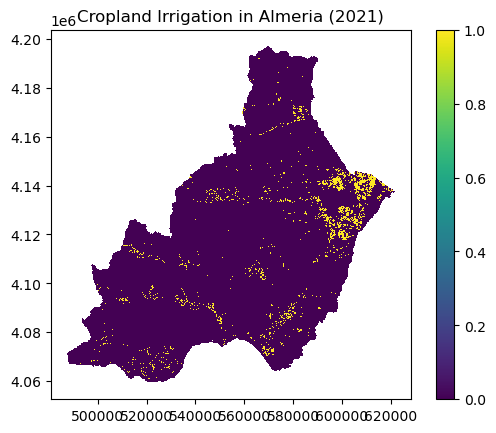

In [10]:
land_2021 = land_use[(land_use["year"] == 2021) & (land_use["prov"] == "Almeria")]
land_2021_merged = grid.merge(land_2021, on="grid_id")
plt.figure(figsize=(8, 5))
land_2021_merged.plot(column="irrigation", legend=True)
plt.title("Cropland Irrigation in Almeria (2021)")
plt.show()

4. Descriptive statistics: compute total area by crop (average across all years), plot total area under irrigation over time (aggregate and by crop). Comment the results.

In [41]:
land_use["crop"]=land_use["LU"]
land_use["crop"].unique()

array(['olive', 'other', 'nuts', 'arable', 'citric'], dtype=object)

In [12]:
# merge land_use with grid
land_merged = land_use.merge(grid, on="grid_id")
area_by_crop= land_merged.groupby(["year","crop"])["area_ha"].sum()
area_by_crop_avg = area_by_crop.groupby("crop").mean().reset_index()
area_by_crop_avg

,crop,area_ha
0,arable,149535.15625
1,citric,9535.93750
2,nuts,59607.03125
3,olive,9780.46875
4,other,801228.12500


In [14]:
# plot total area under irrigation over time
area_by_crop_irrigation = land_merged[land_merged["irrigation"] == 1].groupby(["year", "crop"])["area_ha"].sum().reset_index()
area_irrigation= area_by_crop_irrigation.groupby("year")["area_ha"].sum().reset_index()
area_irrigation.rename(columns={"area_ha": "total"}, inplace=True)

In [16]:
area_by_crop_irrigation = area_by_crop_irrigation.pivot(index="year", columns="crop", values="area_ha")
area_by_crop_irrigation_merged = area_by_crop_irrigation.merge(area_irrigation, on="year")

In [17]:
area_by_crop_irrigation_merged

,year,arable,citric,nuts,olive,other,total
0,2017,72818.75,11343.75,1668.75,3981.25,7962.50,97775.00
1,2018,41193.75,9831.25,1731.25,3962.50,6706.25,63425.00
2,2019,15181.25,8818.75,1587.50,3243.75,5568.75,34400.00
3,2020,14818.75,8775.00,1556.25,3137.50,4962.50,33250.00
4,2021,14162.50,9031.25,1581.25,3150.00,4581.25,32506.25
5,2022,13931.25,9425.00,1712.50,3056.25,4312.50,32437.50
6,2023,14043.75,9506.25,1675.00,3231.25,4062.50,32518.75
7,2024,13887.50,9556.25,1662.50,3187.50,3806.25,32100.00


<Figure size 800x500 with 0 Axes>

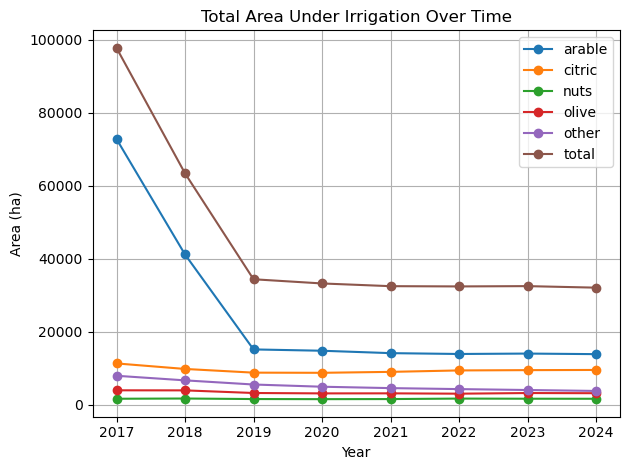

In [18]:
plt.figure(figsize=(8, 5))
# plot the total area under irrigation over time
area_by_crop_irrigation_merged.plot(x="year",marker='o')
plt.title("Total Area Under Irrigation Over Time")
plt.xlabel("Year")
plt.ylabel("Area (ha)")
plt.tight_layout()
plt.grid(True)
plt.show()

# Model

# Identification

## Preview
In the literature, the relationship between expected value function $\bar{V}(s)$ and the $\tilde{u}(s,a)$ and the CCP $\Pr(a|s)$ is given by the following equation:
$$\bar{V}(s)=\gamma + \tilde{u}(s,a)-\ln(\Pr(a|s))$$

To use the notation in the paper, it is 
$$V(k,\omega)=\gamma + \pi_j(k,\omega)+\beta E(V(k',\omega')\mid j,k,\omega)-\ln(\Pr(j|k,\omega))$$
- The correction term $\psi$ corresponds to $\gamma-\ln(\Pr(j|k,\omega))$.
- The continuation value $v_j(k,\omega)$ corresponds to $ \pi_j(k,\omega)+\beta E(V(k',\omega')\mid j,k,\omega)$.

## Question a

$$\Delta\psi_{ja}(k,\omega)= -\pi_j(k,\omega)+\pi_a(k,\omega)-\beta V(j,\omega')+\beta V(a,\omega')-e^v(j,\omega,\omega')+e^v(a,\omega,\omega')$$ 

To write it in the form as in Scott (2013) like an Euler equation, we have
$$\pi_{tj}(k,\omega)-\pi_{ta}(k,\omega)+\Delta\psi_{ja}(k,\omega)= \beta V_{t+1}(j,\omega')-\beta V_{t+1}(a,\omega')+e^v(a,\omega,\omega')-e^v(j,\omega,\omega')$$ 
Using the logit inversion $\psi_j(k,\omega)=\gamma-\ln(\Pr(j|k,\omega))$, we can rewrite the LHS as
$$ \pi_{tj}(k,\omega)-\pi_{ta}(k,\omega)-\ln(\frac{\Pr_t(j|k,\omega)}{\Pr_t(a|k,\omega)}) = \beta V_{t+1}(j,\omega')-\beta V_{t+1}(a,\omega')+e^v(a,\omega,\omega')-e^v(j,\omega,\omega')$$ 
- LHS is the **minimum difference** between in expected profits during period $t$ which justifies the choice of $j$ over $a$.
- RHS is the **expected loss** in continuation values resulting from the joice of $j$ over $a$.

## Question b & c
The relationship of interests is 
$$ V_{t+1}(k,\omega)=\gamma + v_{t+1r}(k,\omega)-\ln(\Pr_{t+1}(r|k,\omega))$$
We can use it to replace the $V$ in the Euler equation.
$$ \pi_{tj}(k,\omega)-\pi_{ta}(k,\omega)-\ln(\frac{\Pr_t(j|k,\omega)}{\Pr_t(a|k,\omega)}) = \beta \left\{v_{t+1r}(j,\omega')-v_{t+1r}(a,\omega') + \ln \frac{\Pr_{t+1}(r|j,\omega')}{\Pr_{t+1}(r|a,\omega')}\right\}+e^v(a,\omega,\omega')-e^v(j,\omega,\omega')$$ 

Denote $r$ to be the renewal action (crop switching),
and that 
$$ v_{t+1r}(j,\omega)=\pi_{t+1r}(j,\omega)+\beta E(V_{t+2}(k',\omega')\mid r,j,\omega)$$
Similarly for $v_{t+1r}(a,\omega)$. And because of renewal, 
$$E(V_{t+2}(k',\omega')\mid r,j,\omega)=E(V_{t+2}(k',\omega')\mid r,a,\omega)$$
Therefore, taking the difference between the two, we have
$$ v_{t+1r}(j,\omega)-v_{t+1r}(a,\omega)= \pi_{t+1r}(j,\omega)-\pi_{t+1r}(a,\omega)$$ 

Therefore, the Euler equation becomes

$$ \pi_{tj}(k,\omega)-\pi_{ta}(k,\omega)-\ln(\frac{\Pr_t(j|k,\omega)}{\Pr_t(a|k,\omega)}) = \beta \left\{\pi_{t+1r}(j,\omega')-\pi_{t+1r}(a,\omega') + \ln \frac{\Pr_{t+1}(r|j,\omega')}{\Pr_{t+1}(r|a,\omega')}\right\}+e^v(a,\omega,\omega')-e^v(j,\omega,\omega')$$ 


## Question d
Rearranging,
$$ \ln(\frac{\Pr_t(j|k,\omega)}{\Pr_t(a|k,\omega)}) + \beta \ln \frac{\Pr_{t+1}(r|j,\omega')}{\Pr_{t+1}(r|a,\omega')}$$ 
$$ = \pi_{tj}(k,\omega)-\pi_{ta}(k,\omega) - \beta (\pi_{t+1r}(j,\omega')-\pi_{t+1r}(a,\omega'))+e^v(a,\omega,\omega')-e^v(j,\omega,\omega')$$

$$=\theta_j-\theta_a + \theta_{kj}-\theta_{ka} + \theta^R R_j(\omega)-\theta^R R_a(\omega) + \xi_j(k,\omega)-\xi_a(k,\omega)+\varepsilon_j(k,\omega)-\varepsilon_a(k,\omega) $$
$$   \beta(\theta_r-\theta_r+\theta_{jr}-\theta_{ar} + \theta^R R_r(\omega')-\theta^R R_r(\omega')+\xi_r(j,\omega')-\xi_r(a,\omega')+\varepsilon_r(j,\omega')-\varepsilon_r(a,\omega'))$$
$$ +e^v(a,\omega,\omega')-e^v(j,\omega,\omega')$$


Fixing the choice $j, a, r$ and aggregate state change $\omega,\omega'$. Define new symboles to rewrite the above regression equation: 
- $Y_{tk} = \ln(\frac{\Pr_t(j|k,\omega)}{\Pr_t(a|k,\omega)}) + \beta \ln \frac{\Pr_{t+1}(r|j,\omega')}{\Pr_{t+1}(r|a,\omega')}$
- $\Delta \alpha_{k} = \theta_j-\theta_a + \theta_{kj}-\theta_{ka}  + \beta(\theta_r-\theta_r+\theta_{jr}-\theta_{ar})$
- $\Delta R_t =R_{jt}(\omega)-R_{at}(\omega)$
- $\Delta \xi_{tk} = \xi_j(k,\omega)-\xi_a(k,\omega)+\beta(\xi_r(j,\omega')-\xi_r(a,\omega'))$
- $\Delta e_{tk}^V=\varepsilon_j(k,\omega)-\varepsilon_a(k,\omega)+\beta(\varepsilon_r(j,\omega')-\varepsilon_r(a,\omega'))$

Then the regression equation can be written as
$$ Y_{tk} = \Delta \alpha_{k}  + \theta ^R \Delta R_t + \Delta \xi_{tk} + \Delta e_{tk}^V$$

## Question e

There is variation in $\Delta R_t(\omega)$ across aggregate states $\omega \in \Omega$. In Scott 2013, most of the variation in $\Delta R= R_{\text{crops},t}-R_{\text{others}}(\omega)$ comes from the variation in $R_{\text{crop}}(\omega)$, instead of from  $R_{\text{others}}(\omega)$  which are proxied by patsture rentral rates.

## Question f
This is essentially a panel data estimation, with time $t$ and unit $k$. 
Firstly, the composite error term $\Delta \xi_{tk} + \Delta e_{tk}^V$ needs to be uncorrelated with the regressors for all $t$.  The condition is likely to fail because of $\xi$. 
Secondly, the fixed effect $\Delta \alpha_{k}$ naturally calls for a first-difference or within transformation to remove the fixed effect, if we don't assume that the persistent $\Delta \alpha_{k}$ is uncorrelated with the regressors for all $t$.
The paper adopts the Arellano-Bond estimator to deal with the above mentioend two problems. 

To write out the moment conditions, we use $\Delta R_{nt}$ to instrument for $\Delta R_{nt+1}-\Delta R_{nt}$.
The requried assumptions are 
$$ \mathbb{E} \left[ \Delta R_{nt} \left( \Delta \tilde{\xi}_{n,t+1} - \Delta \tilde{\xi}_{nt} \right) \right] = 0,$$
$$\mathbb{E} \left[ \Delta R_{nt} \left( \Delta \varepsilon^V_{n,t+1} - \Delta \varepsilon^V_{nt} \right) \right] = 0
$$
Formally, the estimating equation is  
$$Y_{k,t+1} - Y_{kt} 
= \theta^{R} \left( \Delta R_{k,t+1} - \Delta R_{kt} \right) 
+ \left( \Delta \tilde{\xi}_{k,t+1} - \Delta \tilde{\xi}_{kt} \right) 
+ \left( \Delta \varepsilon^V_{k,t+1} - \Delta \varepsilon^V_{kt} \right).
$$


For this estimating equation, Scott (2013) uses *lagged returns variables, expected caloric yields, constant term* as instruments in the moment condition,then proceed with 2-step GMM estimation. 


## Question g

- Restriction: For example, Scott (2013) assumes that the payoff to non-cropland do not depend on the field state, equalizing $\alpha(\text{non-crops},k)=\alpha(\text{non-crops},k')$ for all $k,k'$. 
- Normalization: The author normalizes the payoff of one pair $(j,k)$ that $\alpha(j,k)=0$.
  
This problem set imposes similar parameter restrictions and normalizations.


# Estimation

First, one needs to construct the dependent and independent variables. 
Second, the regression equation is estimated.

In [20]:
from shapely.geometry import Point

1. Estimate the conditional choice probabilities using a frequency estimator for every year and province: $p_{jmt}(k) = \hat{p}_j(k,\omega)$. You will need to deal with zero probabilities.
   1. variables
      - $m$: province
      - $t$: year 
      - $k$: individual state, which is equal to last period's choice (land use and irrgation)
      - $j$: this period choice. (land use and irrgation)
    2. calculate distance between provinces, therefore the weight.
    3. for each $(m,t)$, use frequency estimator to calculate the ccp for $(j,k)$, but with weight defined in the previous step.


In Scott (2013), There is state, county, land. The paper calculates the ccp for each country by taking the other counties in the same state as smoothing input. 

In the problem set, there is province, grid. The ccp is calculated for each province. Other provinces are used as smoothing input. 

In [ ]:
# Approach 1 to calculate province centroids and distances
# Dissolve the grid by province, project for distance in meters, and compute centroids
province_gdf = grid.to_crs(epsg=25830).dissolve(by="prov")
province_gdf["centroid"] = province_gdf.geometry.centroid

# Compute pairwise distance in kilometers (vectorized approach)
dist_matrix = province_gdf["centroid"].apply(lambda x: province_gdf["centroid"].distance(x)) / 1000
dist_matrix

prov,Almeria,Cadiz,Cordoba,Granada,Huelva,Jaen,Malaga,Sevilla
prov,,,,,,,,
Almeria,0.000000,312.211081,224.575912,79.078928,392.650253,113.089106,212.506580,285.151168
Cadiz,312.211081,0.000000,180.601198,241.130048,143.512388,265.130625,99.743919,112.125038
Cordoba,224.575912,180.601198,0.000000,148.180949,185.422069,125.494329,128.577503,85.471411
Granada,79.078928,241.130048,148.180949,0.000000,313.712526,63.474053,142.288198,206.114468
Huelva,392.650253,143.512388,185.422069,313.712526,0.000000,308.381901,203.636431,107.840659
Jaen,113.089106,265.130625,125.494329,63.474053,308.381901,0.000000,174.104698,202.378705
Malaga,212.506580,99.743919,128.577503,142.288198,203.636431,174.104698,0.000000,113.444528
Sevilla,285.151168,112.125038,85.471411,206.114468,107.840659,202.378705,113.444528,0.000000


In [ ]:
# Approach 2 to calculate province centroids and distances
# Calculate centroids of each province using the grid
grid_centroids = grid.dissolve(by="grid_id").centroid

# Create a distance matrix (in kilometers) between province centroids
grid_names = grid_centroids.index.tolist()
n = len(grid_names)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        distance_matrix[i, j] =grid_centroids.iloc[i].distance(grid_centroids.iloc[j]) / 1000  # meters to km

# Create a DataFrame for easier viewing
province_distance_df = pd.DataFrame(distance_matrix, index=grid_names, columns=grid_names)
province_distance_df

In [24]:
# The weighting matrix 
weight_matrix = (1+ dist_matrix)**(-2)
print(weight_matrix)

prov      Almeria     Cadiz   Cordoba   Granada    Huelva      Jaen    Malaga  \
prov                                                                            
Almeria  1.000000  0.000010  0.000020  0.000156  0.000006  0.000077  0.000022   
Cadiz    0.000010  1.000000  0.000030  0.000017  0.000048  0.000014  0.000099   
Cordoba  0.000020  0.000030  1.000000  0.000045  0.000029  0.000062  0.000060   
Granada  0.000156  0.000017  0.000045  1.000000  0.000010  0.000241  0.000049   
Huelva   0.000006  0.000048  0.000029  0.000010  1.000000  0.000010  0.000024   
Jaen     0.000077  0.000014  0.000062  0.000241  0.000010  1.000000  0.000033   
Malaga   0.000022  0.000099  0.000060  0.000049  0.000024  0.000033  1.000000   
Sevilla  0.000012  0.000078  0.000134  0.000023  0.000084  0.000024  0.000076   

prov      Sevilla  
prov               
Almeria  0.000012  
Cadiz    0.000078  
Cordoba  0.000134  
Granada  0.000023  
Huelva   0.000084  
Jaen     0.000024  
Malaga   0.000076  
Sevilla  